In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import xarray as xr
import os
import numpy as np
import logging
import cmocean
import copy

cmocean.cm.balance
cmap = copy.copy(cmocean.cm.balance)
cmap.set_bad('gray')   
###first verage every year and then concate

pp_root_uncou = "/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/postProcessing/NWA12.COBALTuncou/"
pp_root_uncou_LAfalse="/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/postProcessing/NWA12.COBALTuncou_LALTFalse/"
pp_root_12_all="/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/c6/postProcessing/NWA12_wave_all/"
pp_root_12_wave="/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/c6/postProcessing/NWA12_wave/"
pp_root_6_all="/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/c6/postProcessing/NWA12_6_all/"
pp_root_6_wave="/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/c6/postProcessing/NWA12_6_wave/"
def read_and_extract_data(pp_root, data_list, variables,x_coord,y_coord):
    combined_data = {}
    summer_data = {}
    winter_data = {}

    for var_name in variables:
        datasets = []
        summer_data_list = []
        winter_data_list = []

        for file_path in data_list:
            file_path = os.path.join(pp_root, file_path)
            if os.path.exists(file_path):
                try:
                    ds = xr.open_dataset(file_path)
                    if var_name in ds:
                        
                      
                        
                        wave_time = ds[var_name].sel(xh=x_coord, yh=y_coord, method="nearest")
                        exact_xh = wave_time.xh.values
                        exact_yh = wave_time.yh.values
                        datasets.append(wave_time)
                        
                        print(f"Exact xh: {exact_xh}, Exact yh: {exact_yh}")

                        # Summer: June, July, August (JJA)
                        summer = ds.sel(time=ds['time'].dt.month.isin([6, 7, 8]))
                        if not summer[var_name].isnull().all():
                            summer_mean = summer[var_name].sel(xh=x_coord, yh=y_coord, method="nearest")
                            exact_xh = summer_mean.xh.values
                            exact_yh = summer_mean.yh.values
                            print(f"Exact xh: {exact_xh}, Exact yh: {exact_yh}")
                            
                            summer_data_list.append(summer_mean)

                        # Winter: December, January, February (DJF)
                        winter = ds.sel(time=ds['time'].dt.month.isin([12, 1, 2]))
                        if not winter[var_name].isnull().all():
                            winter_mean=winter[var_name].sel(xh=x_coord, yh=y_coord, method="nearest")
                            exact_xh = winter_mean.xh.values
                            exact_yh = winter_mean.yh.values
                            print(f"Exact xh: {exact_xh}, Exact yh: {exact_yh}")
                            winter_data_list.append(winter_mean)

                    else:
                        print(f"Variable {var_name} not found in {file_path}")
                    ds.close()

                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
            else:
                print(f"File not found: {file_path}")

        # Combine along time dimension after the loop finishes
        combined_data[var_name] = xr.concat(datasets, dim='time') if datasets else None
        summer_data[var_name] = xr.concat(summer_data_list, dim='time') if summer_data_list else None
        winter_data[var_name] = xr.concat(winter_data_list, dim='time') if winter_data_list else None

    return combined_data, summer_data, winter_data
def read_and_extract_data_multi(pp_root, data_list, variables, points):

    combined_data = {var: {} for var in variables}
    summer_data = {var: {} for var in variables}
    winter_data = {var: {} for var in variables}

    for var_name in variables:
        for point in points:
            x_coord, y_coord = point
            datasets = []
            summer_data_list = []
            winter_data_list = []

            for file_path in data_list:
                file_path = os.path.join(pp_root, file_path)
                if os.path.exists(file_path):
                    try:
                        ds = xr.open_dataset(file_path)
                        if var_name in ds:
                            
                            # Extract data at the nearest (xh, yh) to the given (x_coord, y_coord)
                            wave_time = ds[var_name].sel(xh=x_coord, yh=y_coord, method="nearest")
                            # exact_xh = wave_time.xh.values
                            # exact_yh = wave_time.yh.values
                            datasets.append(wave_time)
                            
                            # print(f"Exact xh: {exact_xh}, Exact yh: {exact_yh}")
                       

                            # Summer: June, July, August (JJA)
                            summer = ds.sel(time=ds['time'].dt.month.isin([6, 7, 8]))
                            if not summer[var_name].isnull().all():
                                summer_mean = summer[var_name].sel(xh=x_coord, yh=y_coord, method="nearest")
                                summer_data_list.append(summer_mean)
                                # exact_xh = summer_mean.xh.values
                                # exact_yh = summer_mean.yh.values
                             
                            
                                # print(f"summer Exact xh: {exact_xh}, Exact yh: {exact_yh}")

                            # Winter: December, January, February (DJF)
                            winter = ds.sel(time=ds['time'].dt.month.isin([12, 1, 2]))
                            if not winter[var_name].isnull().all():
                                winter_mean = winter[var_name].sel(xh=x_coord, yh=y_coord, method="nearest")
                                # exact_xh = winter_mean.xh.values
                                # exact_yh = winter_mean.yh.values
                                winter_data_list.append(winter_mean)
                                # print(f"winter Exact xh: {exact_xh}, Exact yh: {exact_yh}")

                        else:
                            print(f"Variable {var_name} not found in {file_path}")
                        ds.close()

                    except Exception as e:
                        print(f"Error reading {file_path}: {e}")
                else:
                    print(f"File not found: {file_path}")

            # Store extracted data per point in a nested dictionary
            combined_data[var_name][point] = xr.concat(datasets, dim='time') if datasets else None
            summer_data[var_name][point] = xr.concat(summer_data_list, dim='time') if summer_data_list else None
            winter_data[var_name][point] = xr.concat(winter_data_list, dim='time') if winter_data_list else None

    return combined_data, summer_data, winter_data
Ddata_list = [
    '19930101_results/19930101.ocean_daily.nc',
    '19930701_results/19930701.ocean_daily.nc',
    '19940101_results/19940101.ocean_daily.nc',
    '19940701_results/19940701.ocean_daily.nc',
    '19950101_results/19950101.ocean_daily.nc',
    '19950701_results/19950701.ocean_daily.nc',
    '19960101_results/19960101.ocean_daily.nc',
    '19970101_results/19970101.ocean_daily.nc',
    '19980101_results/19980101.ocean_daily.nc',
    '19990101_results/19990101.ocean_daily.nc',
    '20000101_results/20000101.ocean_daily.nc',
    '20010101_results/20010101.ocean_daily.nc',
    '20020101_results/20020101.ocean_daily.nc',
    '20030101_results/20030101.ocean_daily.nc',
    '20040101_results/20040101.ocean_daily.nc',
    '20050101_results/20050101.ocean_daily.nc',
    '20060101_results/20060101.ocean_daily.nc',
    '20070101_results/20070101.ocean_daily.nc',
    '20080101_results/20080101.ocean_daily.nc',
    '20090101_results/20090101.ocean_daily.nc',
    '20100101_results/20100101.ocean_daily.nc',
    '20110101_results/20110101.ocean_daily.nc',
    '20120101_results/20120101.ocean_daily.nc',
    '20130101_results/20130101.ocean_daily.nc',
    '20140101_results/20140101.ocean_daily.nc',
    '20150101_results/20150101.ocean_daily.nc',
    '20160101_results/20160101.ocean_daily.nc',
    '20170101_results/20170101.ocean_daily.nc',
    '20180101_results/20180101.ocean_daily.nc',
    '20190101_results/20190101.ocean_daily.nc',
    '20200101_results/20200101.ocean_daily.nc',
    '20210101_results/20210101.ocean_daily.nc',
    '20220101_results/20220101.ocean_daily.nc',

]
Mdata_list = [
    '19930101_results/19930101.ocean_month.nc',
    '19930701_results/19930701.ocean_month.nc',
    '19940101_results/19940101.ocean_month.nc',
    '19940701_results/19940701.ocean_month.nc',
    '19950101_results/19950101.ocean_month.nc',
    '19950701_results/19950701.ocean_month.nc',
    '19960101_results/19960101.ocean_month.nc',
    '19970101_results/19970101.ocean_month.nc',
    '19980101_results/19980101.ocean_month.nc',
    '19990101_results/19990101.ocean_month.nc',
    '20000101_results/20000101.ocean_month.nc',
    '20010101_results/20010101.ocean_month.nc',
    '20020101_results/20020101.ocean_month.nc',
    '20030101_results/20030101.ocean_month.nc',
    '20040101_results/20040101.ocean_month.nc',
    '20050101_results/20050101.ocean_month.nc',
    '20060101_results/20060101.ocean_month.nc',
    '20070101_results/20070101.ocean_month.nc',
    '20080101_results/20080101.ocean_month.nc',
    '20090101_results/20090101.ocean_month.nc',
    '20100101_results/20100101.ocean_month.nc',
    '20110101_results/20110101.ocean_month.nc',
    '20120101_results/20120101.ocean_month.nc',
    '20130101_results/20130101.ocean_month.nc',
    '20140101_results/20140101.ocean_month.nc',
    '20150101_results/20150101.ocean_month.nc',
    '20160101_results/20160101.ocean_month.nc',
    '20170101_results/20170101.ocean_month.nc',
    '20180101_results/20180101.ocean_month.nc',
    '20190101_results/20190101.ocean_month.nc',
    '20200101_results/20200101.ocean_month.nc',
    '20210101_results/20210101.ocean_month.nc',
    '20220101_results/20220101.ocean_month.nc',

]
WMdata_list = [
    '19930101_results/19930101.ocean_month.nc',
    '19930701_results/19930701.ocean_month.nc',
    '19940101_results/19940101.ocean_month.nc',
    '19940701_results/19940701.ocean_month.nc',
    '19950101_results/19950101.ocean_month.nc',
    '19950701_results/19950701.ocean_month.nc',
    '19960101_results/19960101.ocean_month.nc',
    '19960701_results/19960701.ocean_month.nc',
    '19970101_results/19970101.ocean_month.nc',
    '19970701_results/19970701.ocean_month.nc',
    '19980101_results/19980101.ocean_month.nc',
    '19980701_results/19980701.ocean_month.nc',
    '19990101_results/19990101.ocean_month.nc',
    '19990701_results/19990701.ocean_month.nc',
    '20000101_results/20000101.ocean_month.nc',
    '20000701_results/20000701.ocean_month.nc',
    '20010101_results/20010101.ocean_month.nc',
    '20010701_results/20010701.ocean_month.nc',
    '20020101_results/20020101.ocean_month.nc',
    '20020701_results/20020701.ocean_month.nc',
    '20030101_results/20030101.ocean_month.nc',
    '20030701_results/20030701.ocean_month.nc',
    '20040101_results/20040101.ocean_month.nc',
    '20040701_results/20040701.ocean_month.nc',
    '20050101_results/20050101.ocean_month.nc',
    '20050701_results/20050701.ocean_month.nc',
    '20060101_results/20060101.ocean_month.nc',
    '20060701_results/20060701.ocean_month.nc',
    '20070101_results/20070101.ocean_month.nc',
    '20070701_results/20070701.ocean_month.nc',
    '20080101_results/20080101.ocean_month.nc',
    '20080701_results/20080701.ocean_month.nc',
    '20090101_results/20090101.ocean_month.nc',
    '20090701_results/20090701.ocean_month.nc',
    '20100101_results/20100101.ocean_month.nc',
    '20100701_results/20100701.ocean_month.nc',
    '20110101_results/20110101.ocean_month.nc',
    '20110701_results/20110701.ocean_month.nc',
    '20120101_results/20120101.ocean_month.nc',
    '20120701_results/20120701.ocean_month.nc',
    '20130101_results/20130101.ocean_month.nc',
    '20130701_results/20130701.ocean_month.nc',
    '20140101_results/20140101.ocean_month.nc',
    '20140701_results/20140701.ocean_month.nc',
    '20150101_results/20150101.ocean_month.nc',
    '20150701_results/20150701.ocean_month.nc',
    '20160101_results/20160101.ocean_month.nc',
    '20160701_results/20160701.ocean_month.nc',
    '20170101_results/20170101.ocean_month.nc',
    '20170701_results/20170701.ocean_month.nc',
    '20180101_results/20180101.ocean_month.nc',
    '20180701_results/20180701.ocean_month.nc',
    '20190101_results/20190101.ocean_month.nc',
    '20190701_results/20190701.ocean_month.nc',
    '20200101_results/20200101.ocean_month.nc',
    '20200701_results/20200701.ocean_month.nc',
    '20210101_results/20210101.ocean_month.nc',
    '20210701_results/20210701.ocean_month.nc',
    '20220101_results/20220101.ocean_month.nc',
    '20220701_results/20220701.ocean_month.nc',
]

WDdata_list = [
    '19930101_results/19930101.ocean_daily.nc',
    '19930701_results/19930701.ocean_daily.nc',
    '19940101_results/19940101.ocean_daily.nc',
    '19940701_results/19940701.ocean_daily.nc',
    '19950101_results/19950101.ocean_daily.nc',
    '19950701_results/19950701.ocean_daily.nc',
    '19960101_results/19960101.ocean_daily.nc',
    '19960701_results/19960701.ocean_daily.nc',
    '19970101_results/19970101.ocean_daily.nc',
    '19970701_results/19970701.ocean_daily.nc',
    '19980101_results/19980101.ocean_daily.nc',
    '19980701_results/19980701.ocean_daily.nc',
    '19990101_results/19990101.ocean_daily.nc',
    '19990701_results/19990701.ocean_daily.nc',
    '20000101_results/20000101.ocean_daily.nc',
    '20000701_results/20000701.ocean_daily.nc',
    '20010101_results/20010101.ocean_daily.nc',
    '20010701_results/20010701.ocean_daily.nc',
    '20020101_results/20020101.ocean_daily.nc',
    '20020701_results/20020701.ocean_daily.nc',
    '20030101_results/20030101.ocean_daily.nc',
    '20030701_results/20030701.ocean_daily.nc',
    '20040101_results/20040101.ocean_daily.nc',
    '20040701_results/20040701.ocean_daily.nc',
    '20050101_results/20050101.ocean_daily.nc',
    '20050701_results/20050701.ocean_daily.nc',
    '20060101_results/20060101.ocean_daily.nc',
    '20060701_results/20060701.ocean_daily.nc',
    '20070101_results/20070101.ocean_daily.nc',
    '20070701_results/20070701.ocean_daily.nc',
    '20080101_results/20080101.ocean_daily.nc',
    '20080701_results/20080701.ocean_daily.nc',
    '20090101_results/20090101.ocean_daily.nc',
    '20090701_results/20090701.ocean_daily.nc',
    '20100101_results/20100101.ocean_daily.nc',
    '20100701_results/20100701.ocean_daily.nc',
    '20110101_results/20110101.ocean_daily.nc',
    '20110701_results/20110701.ocean_daily.nc',
    '20120101_results/20120101.ocean_daily.nc',
    '20120701_results/20120701.ocean_daily.nc',
    '20130101_results/20130101.ocean_daily.nc',
    '20130701_results/20130701.ocean_daily.nc',
    '20140101_results/20140101.ocean_daily.nc',
    '20140701_results/20140701.ocean_daily.nc',
    '20150101_results/20150101.ocean_daily.nc',
    '20150701_results/20150701.ocean_daily.nc',
    '20160101_results/20160101.ocean_daily.nc',
    '20160701_results/20160701.ocean_daily.nc',
    '20170101_results/20170101.ocean_daily.nc',
    '20170701_results/20170701.ocean_daily.nc',
    '20180101_results/20180101.ocean_daily.nc',
    '20180701_results/20180701.ocean_daily.nc',
    '20190101_results/20190101.ocean_daily.nc',
    '20190701_results/20190701.ocean_daily.nc',
    '20200101_results/20200101.ocean_daily.nc',
    '20200701_results/20200701.ocean_daily.nc',
    '20210101_results/20210101.ocean_daily.nc',
    '20210701_results/20210701.ocean_daily.nc',
    '20220101_results/20220101.ocean_daily.nc',
    '20220701_results/20220701.ocean_daily.nc',
]

# variables_month = ['ssh','speed','MLD_EN1','LA','LA_MOD','MSTAR_LT','La_turbulent','surface_stokes_x','surface_stokes_y']
variables_daily = ['SST']
# points = [(-45, 10), (-52, 26), (-53, 35)]
points = [(-45, 10)]
Dcombined_data_uncou, Dsummer_data_uncou, Dwinter_data_uncou = read_and_extract_data_multi(pp_root_uncou, Ddata_list, variables_daily,points)

Dcombined_data_6_wave, Dsummer_data_6_wave, Dwinter_data_6_wave = read_and_extract_data_multi(pp_root_6_wave, WDdata_list, variables_daily,points)

# Dcombined_data_6_all, Dsummer_data_6_all, Dwinter_data_6_all = read_and_extract_data_multi(pp_root_6_all, WDdata_list, variables_daily,points)

ocean_daily_uncou_1= xr.open_dataset(pp_root_uncou+"/19930101_results/19930101.ocean_daily.nc")
model_grid_x = ocean_daily_uncou_1.variables['xh']
model_grid_y = ocean_daily_uncou_1.variables['yh']



/vftmp/Qian.Xiao/pid1887975/ipykernel_1892005/2563548533.py:98: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_path)


Exact xh: -44.959991455078125, Exact yh: 10.028401374816895
summer Exact xh: -44.959991455078125, Exact yh: 10.028401374816895
winter Exact xh: -44.959991455078125, Exact yh: 10.028401374816895


/vftmp/Qian.Xiao/pid1887975/ipykernel_1892005/2563548533.py:98: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_path)


Exact xh: -44.959991455078125, Exact yh: 10.028401374816895
summer Exact xh: -44.959991455078125, Exact yh: 10.028401374816895


KeyboardInterrupt: 

In [14]:
ocean_daily_6_wave_1= xr.open_dataset(pp_root_uncou+"/20030101_results/20030101.ocean_month.nc")
ocean_daily_6_wave_2= xr.open_dataset(pp_root_6_wave+"/20030701_results/20030701.ocean_month.nc")
x_coord=-45
y_coord=10
wave_time = ocean_daily_6_wave_1['SST'].sel(xh=x_coord, yh=y_coord, method="nearest")
wave_time_2 = ocean_daily_6_wave_2['SST'].sel(xh=x_coord, yh=y_coord, method="nearest")
# plt.figure
# wave_time.plot()
# plt.show()
print(wave_time.values)
print(wave_time_2.values)

/vftmp/Qian.Xiao/pid1887975/ipykernel_1892005/1838134647.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ocean_daily_6_wave_1= xr.open_dataset(pp_root_uncou+"/20030101_results/20030101.ocean_month.nc")
/vftmp/Qian.Xiao/pid1887975/ipykernel_1892005/1838134647.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ocean_daily_6_wave_2= xr.open_dataset(pp_root_6_wave+"/20030701_results/20030701.ocean_month.nc")


KeyError: "No variable named 'SST'. Variables on the dataset include ['xh', 'yh', 'zl', 'time', 'nv', ..., 'MSTAR', 'average_T1', 'average_T2', 'average_DT', 'time_bnds']"

<xarray.DataArray 'SST' ()>
array(0.0547657)


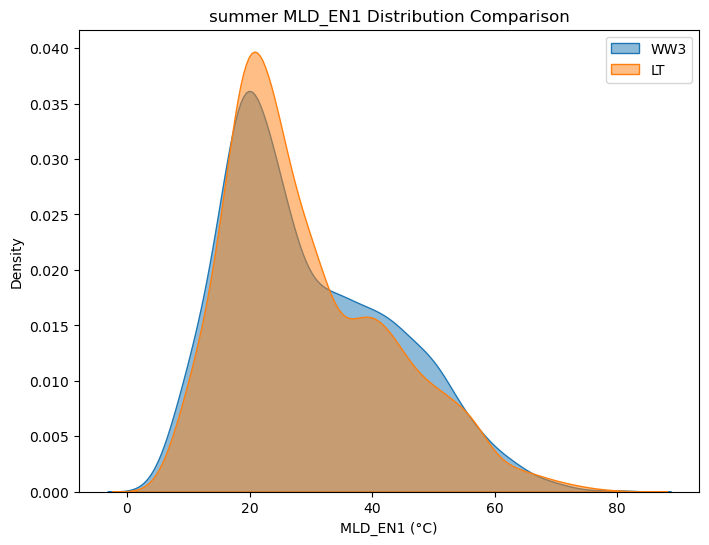

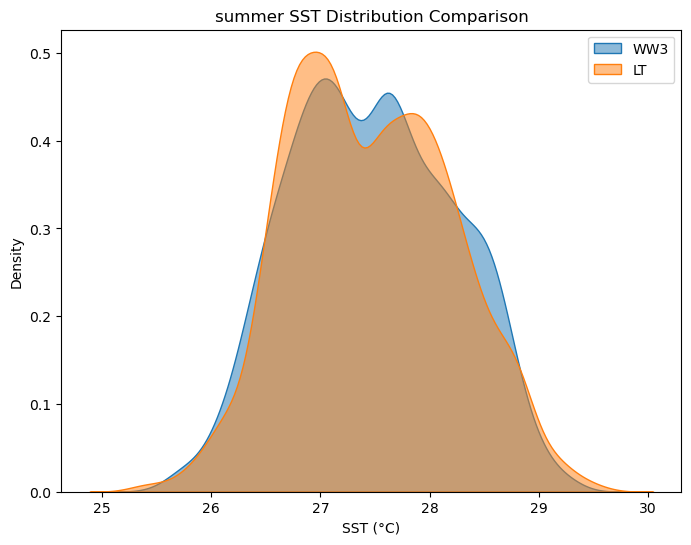

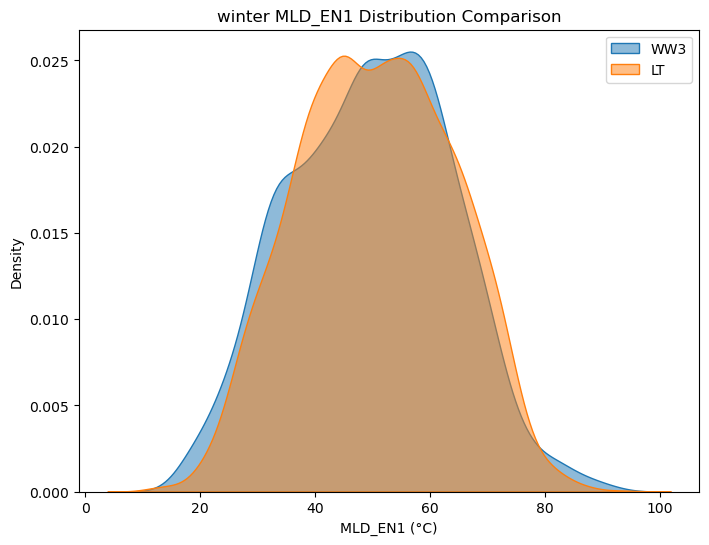

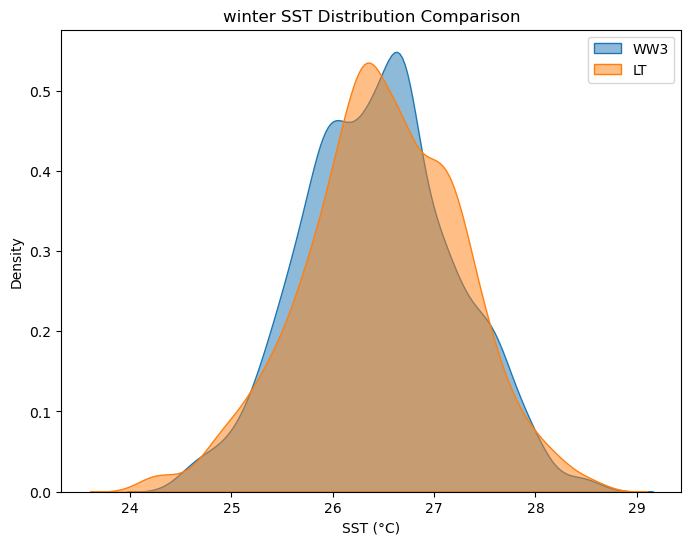

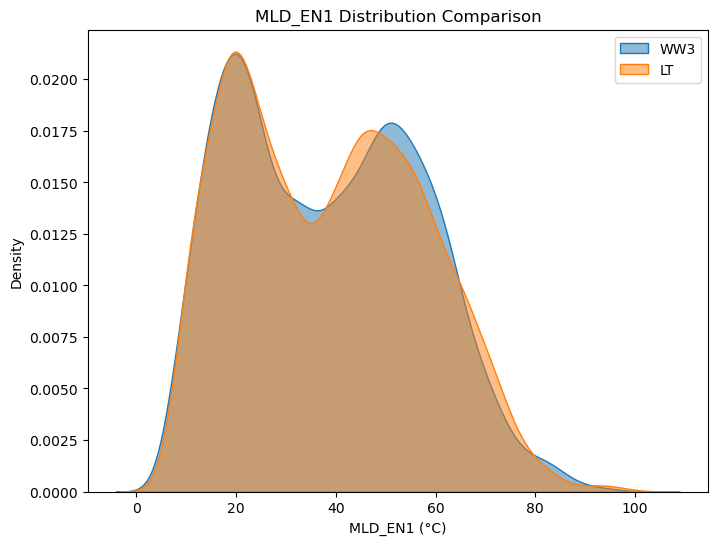

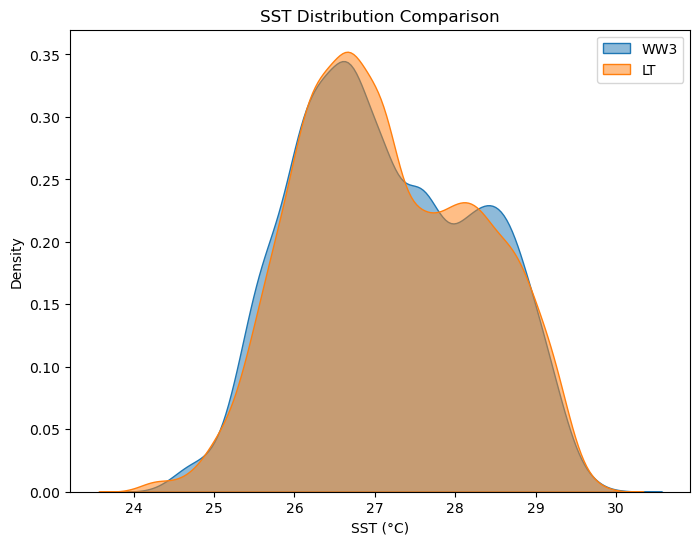

[[27.1465168  27.14243698 27.16162682]
 [38.56602097 38.50647354 38.63376236]
 [27.48535919 27.46787453 27.45991898]
 [29.29330635 29.72514725 29.41722488]
 [26.47495461 26.4487896  26.48848534]
 [49.76704407 49.64753342 50.55149078]]
[[27.04988098 27.02288437 27.04260445]
 [38.89759445 38.06242752 38.26000595]
 [27.51691246 27.45503044 27.4314537 ]
 [26.23133469 26.2138443  25.75885391]
 [26.44080353 26.45166588 26.47988129]
 [49.79390335 49.90740967 50.70423508]]
T-test p-value: 0.20146852971599438
The SST difference is NOT statistically significant.
T-test p-value: 0.6140432581303145
The MLD_EN1 difference is NOT statistically significant.


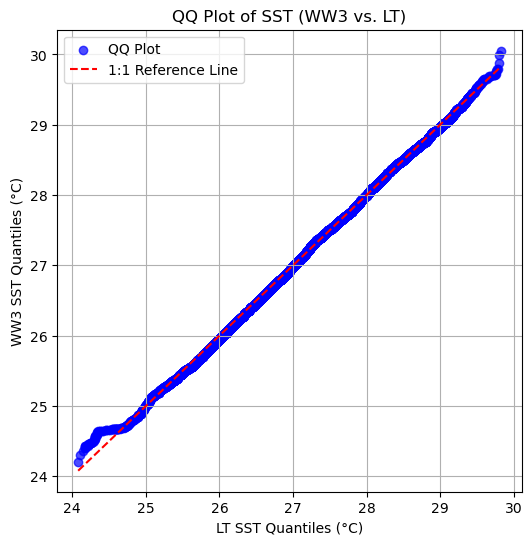

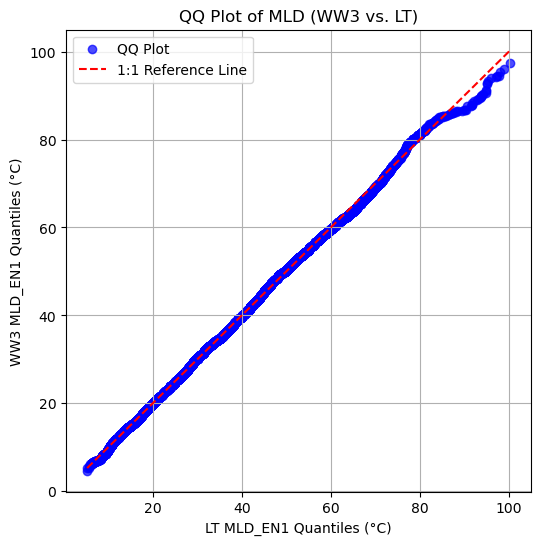

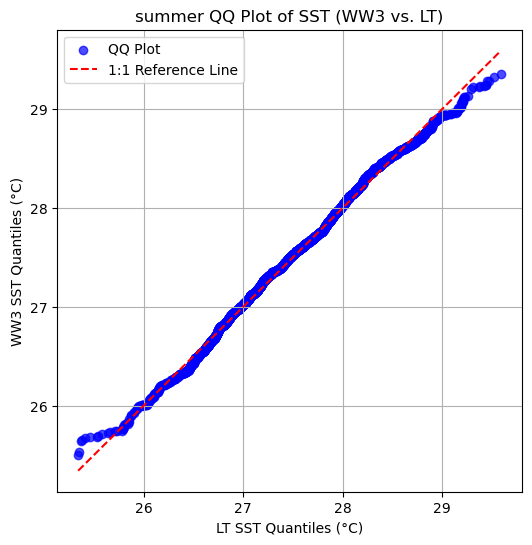

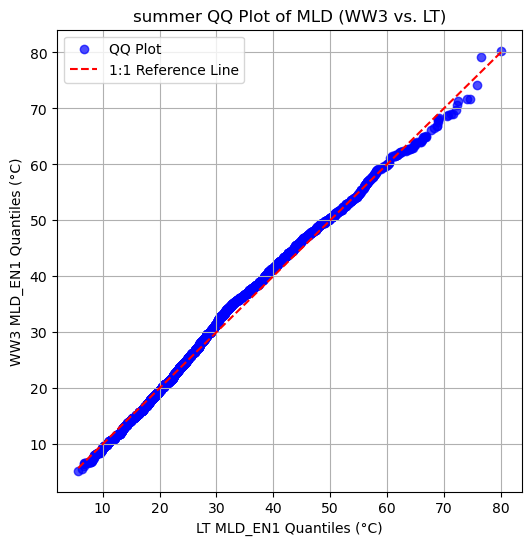

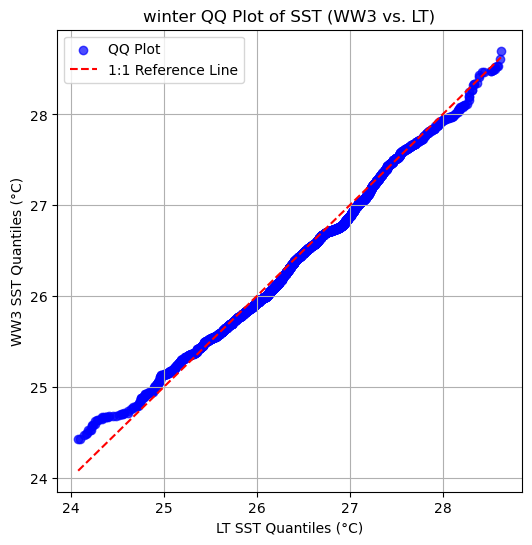

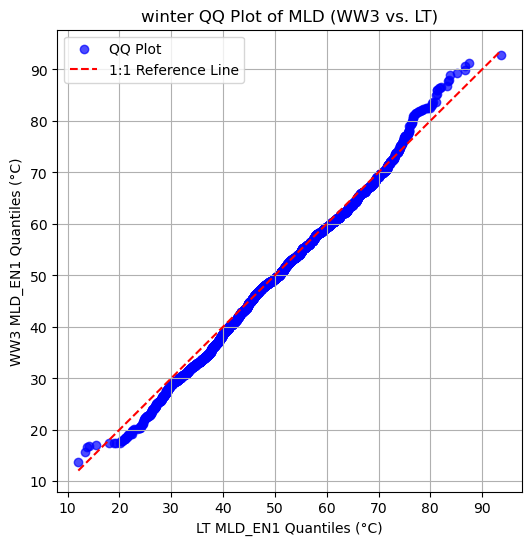

In [37]:
# plt.figure(figsize=(15, 5))

# # Plot the first dataset
# # Dcombined_data_6_all['SST'][(-45, 10)].plot(label='NWA6 CT+LT SST')
# # Plot the second dataset
# Dcombined_data_6_wave['SST'][(-45, 10)].plot(label='NWA6 LT SST')
# # Add more datasets if needed
# Dcombined_data_uncou['SST'][(-45, 10)].plot(label='uncou SST')

# Add title, labels, and legend
# plt.title('SST Time Series Comparison for points (-45, 10)')
# plt.xlabel('Time')
# plt.ylabel('SST (°C)')
# plt.legend()

# # Show the plot
# plt.show()
# plt.figure(figsize=(15, 5))

# # Plot the first dataset
# # Dcombined_data_6_all['MLD_EN1'][(-45, 10)].plot(label='NWA6 CT+LT MLD_EN1')
# # Plot the second dataset
# Dcombined_data_6_wave['MLD_EN1'][(-45, 10)].plot(label='NWA6 LT MLD_EN1')
# # Add more datasets if needed
# Dcombined_data_uncou['MLD_EN1'][(-45, 10)].plot(label='uncou MLD_EN1')

# # Add title, labels, and legend
# plt.title('MLD_EN1 Time Series Comparison for points (-45, 10)')
# plt.xlabel('Time')
# plt.ylabel('MLD_EN1 (°C)')
# plt.legend()

# # Show the plot
# plt.show()

# plt.figure(figsize=(15, 5))

# Dsummer_data_6_wave['SST'][(-45, 10)].plot(label='NWA6 LT SST')
# # Add more datasets if needed
# Dsummer_data_uncou['SST'][(-45, 10)].plot(label='uncou SST')

# # Add title, labels, and legend
# plt.title('SST summer Time Series Comparison for points (-45, 10)')
# plt.xlabel('Time')
# plt.ylabel('SST (°C)')
# plt.xticks(rotation=45)
# plt.legend()

# # Show the plot
# plt.show()
# plt.figure(figsize=(15, 5))

# # Dwinter_data_6_all['SST'][(-45, 10)].plot(label='NWA6 CT+LT SST')
# # Plot the second dataset
# Dwinter_data_6_wave['SST'][(-45, 10)].plot(label='NWA6 LT SST')
# # Add more datasets if needed
# Dwinter_data_uncou['SST'][(-45, 10)].plot(label='uncou SST')

# # Add title, labels, and legend
# plt.title('SST winter Time Series Comparison for points (-45, 10)')
# plt.xlabel('Time')
# plt.ylabel('SST (°C)')
# plt.xticks(rotation=45)
# plt.legend()

# # Show the plot
# plt.show()


# plt.figure(figsize=(15, 5))
# # plt.plot(Dsummer_data_6_all['MLD_EN1'][(-45, 10)]['time'], Dsummer_data_6_all['MLD_EN1'][(-45, 10)], label="NWA6 CT+LT MLD_EN1")
# # Plot the first dataset
# # Dsummer_data_6_all['MLD_EN1'][(-45, 10)].plot(label='NWA6 CT+LT MLD_EN1')
# # Plot the second dataset
# Dsummer_data_6_wave['MLD_EN1'][(-45, 10)].plot(label='NWA6 LT MLD_EN1')
# # Add more datasets if needed
# Dsummer_data_uncou['MLD_EN1'][(-45, 10)].plot(label='uncou MLD_EN1')

# # Add title, labels, and legend
# plt.title('MLD_EN1 summer Time Series Comparison for points (-45, 10)')
# plt.xlabel('Time')
# plt.ylabel('MLD_EN1 (°C)')
# plt.xticks(rotation=45)
# plt.legend()

# # Show the plot
# plt.show()
# plt.figure(figsize=(15, 5))

# # Dwinter_data_6_all['MLD_EN1'][(-45, 10)].plot(label='NWA6 CT+LT MLD_EN1')
# # Plot the second dataset
# Dwinter_data_6_wave['MLD_EN1'][(-45, 10)].plot(label='NWA6 LT MLD_EN1')
# # Add more datasets if needed
# Dwinter_data_uncou['MLD_EN1'][(-45, 10)].plot(label='uncou MLD_EN1')

# # Add title, labels, and legend
# plt.title('MLD_EN1 winter Time Series Comparison for points (-45, 10)')
# plt.xlabel('Time')
# plt.ylabel('MLD_EN1 (°C)')
# plt.xticks(rotation=45)
# plt.legend()

# # Show the plot
# plt.show()
SST_25th_WW3 = Dcombined_data_6_wave['SST'][(-45, 10)].quantile(0.25, dim='time')
SST_75th_WW3 = Dcombined_data_6_wave['SST'][(-45, 10)].quantile(0.75, dim='time')

SST_25th_LT = Dcombined_data_uncou['SST'][(-45, 10)].quantile(0.25, dim='time')
SST_75th_LT = Dcombined_data_uncou['SST'][(-45, 10)].quantile(0.75, dim='time')

IQR_diff = (SST_75th_WW3 - SST_25th_WW3) - (SST_75th_LT - SST_25th_LT)

print(IQR_diff)
MLD_25th_WW3 = Dcombined_data_6_wave['MLD_EN1'][(-45, 10)].quantile(0.25, dim='time')
MLD_75th_WW3 = Dcombined_data_6_wave['MLD_EN1'][(-45, 10)].quantile(0.75, dim='time')

MLD_25th_LT = Dcombined_data_uncou['MLD_EN1'][(-45, 10)].quantile(0.25, dim='time')
MLD_75th_LT = Dcombined_data_uncou['MLD_EN1'][(-45, 10)].quantile(0.75, dim='time')

IQR_diff = (MLD_75th_WW3 - MLD_25th_WW3) - (MLD_75th_LT - MLD_25th_LT)

import seaborn as sns

plt.figure(figsize=(8,6))
sns.kdeplot(Dsummer_data_6_wave['MLD_EN1'][(-45, 10)].values.flatten(), label="WW3", fill=True, alpha=0.5)
sns.kdeplot(Dsummer_data_uncou['MLD_EN1'][(-45, 10)].values.flatten(), label="LT", fill=True, alpha=0.5)
plt.xlabel("MLD_EN1 (°C)")
plt.ylabel("Density")
plt.title("summer MLD_EN1 Distribution Comparison")
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
sns.kdeplot(Dsummer_data_6_wave['SST'][(-45, 10)].values.flatten(), label="WW3", fill=True, alpha=0.5)
sns.kdeplot(Dsummer_data_uncou['SST'][(-45, 10)].values.flatten(), label="LT", fill=True, alpha=0.5)
plt.xlabel("SST (°C)")
plt.ylabel("Density")
plt.title("summer SST Distribution Comparison")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
sns.kdeplot(Dwinter_data_6_wave['MLD_EN1'][(-45, 10)].values.flatten(), label="WW3", fill=True, alpha=0.5)
sns.kdeplot(Dwinter_data_uncou['MLD_EN1'][(-45, 10)].values.flatten(), label="LT", fill=True, alpha=0.5)
plt.xlabel("MLD_EN1 (°C)")
plt.ylabel("Density")
plt.title("winter MLD_EN1 Distribution Comparison")
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
sns.kdeplot(Dwinter_data_6_wave['SST'][(-45, 10)].values.flatten(), label="WW3", fill=True, alpha=0.5)
sns.kdeplot(Dwinter_data_uncou['SST'][(-45, 10)].values.flatten(), label="LT", fill=True, alpha=0.5)
plt.xlabel("SST (°C)")
plt.ylabel("Density")
plt.title("winter SST Distribution Comparison")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
sns.kdeplot(Dcombined_data_6_wave['MLD_EN1'][(-45, 10)].values.flatten(), label="WW3", fill=True, alpha=0.5)
sns.kdeplot(Dcombined_data_uncou['MLD_EN1'][(-45, 10)].values.flatten(), label="LT", fill=True, alpha=0.5)
plt.xlabel("MLD_EN1 (°C)")
plt.ylabel("Density")
plt.title("MLD_EN1 Distribution Comparison")
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
sns.kdeplot(Dcombined_data_6_wave['SST'][(-45, 10)].values.flatten(), label="WW3", fill=True, alpha=0.5)
sns.kdeplot(Dcombined_data_uncou['SST'][(-45, 10)].values.flatten(), label="LT", fill=True, alpha=0.5)
plt.xlabel("SST (°C)")
plt.ylabel("Density")
plt.title("SST Distribution Comparison")
plt.legend()
plt.show()

mean=np.zeros((6,3))

mean[0,:]=[Dcombined_data_6_all['SST'][(-45, 10)].mean(dim='time', skipna=True),Dcombined_data_6_wave['SST'][(-45, 10)].mean(dim='time', skipna=True),Dcombined_data_uncou['SST'][(-45, 10)].mean(dim='time', skipna=True)]
mean[1,:]=[Dcombined_data_6_all['MLD_EN1'][(-45, 10)].mean(dim='time', skipna=True),Dcombined_data_6_wave['MLD_EN1'][(-45, 10)].mean(dim='time', skipna=True),Dcombined_data_uncou['MLD_EN1'][(-45, 10)].mean(dim='time', skipna=True)]
mean[2,:]=[Dsummer_data_6_all['SST'][(-45, 10)].mean(dim='time', skipna=True),Dsummer_data_6_wave['SST'][(-45, 10)].mean(dim='time', skipna=True),Dsummer_data_uncou['SST'][(-45, 10)].mean(dim='time', skipna=True)]
mean[3,:]=[Dsummer_data_6_all['MLD_EN1'][(-45, 10)].mean(dim='time', skipna=True),Dsummer_data_6_wave['MLD_EN1'][(-45, 10)].mean(dim='time', skipna=True),Dsummer_data_uncou['MLD_EN1'][(-45, 10)].mean(dim='time', skipna=True)]
mean[4,:]=[Dwinter_data_6_all['SST'][(-45, 10)].mean(dim='time', skipna=True),Dwinter_data_6_wave['SST'][(-45, 10)].mean(dim='time', skipna=True),Dwinter_data_uncou['SST'][(-45, 10)].mean(dim='time', skipna=True)]
mean[5,:]=[Dwinter_data_6_all['MLD_EN1'][(-45, 10)].mean(dim='time', skipna=True),Dwinter_data_6_wave['MLD_EN1'][(-45, 10)].mean(dim='time', skipna=True),Dwinter_data_uncou['MLD_EN1'][(-45, 10)].mean(dim='time', skipna=True)]
print(mean)

median=np.zeros((6,3))

median[0,:]=[Dcombined_data_6_all['SST'][(-45, 10)].median('time'),Dcombined_data_6_wave['SST'][(-45, 10)].median('time'),Dcombined_data_uncou['SST'][(-45, 10)].median('time')]
median[1,:]=[Dcombined_data_6_all['MLD_EN1'][(-45, 10)].median('time'),Dcombined_data_6_wave['MLD_EN1'][(-45, 10)].median('time'),Dcombined_data_uncou['MLD_EN1'][(-45, 10)].median('time')]
median[2,:]=[Dsummer_data_6_all['SST'][(-45, 10)].median('time'),Dsummer_data_6_wave['SST'][(-45, 10)].median('time'),Dsummer_data_uncou['SST'][(-45, 10)].median('time')]
median[3,:]=[Dsummer_data_6_all['MLD_EN1'][(-45, 10)].median('time'),Dsummer_data_6_wave['MLD_EN1'][(-45, 10)].median('time'),Dsummer_data_uncou['MLD_EN1'][(-45, 10)].median('time')]
median[4,:]=[Dwinter_data_6_all['SST'][(-45, 10)].median('time'),Dwinter_data_6_wave['SST'][(-45, 10)].median('time'),Dwinter_data_uncou['SST'][(-45, 10)].median('time')]
median[5,:]=[Dwinter_data_6_all['MLD_EN1'][(-45, 10)].median('time'),Dwinter_data_6_wave['MLD_EN1'][(-45, 10)].median('time'),Dwinter_data_uncou['MLD_EN1'][(-45, 10)].median('time')]
print(median)


import scipy.stats as stats

sst_ww3 = Dcombined_data_6_wave['SST'][(-45, 10)].values.flatten()
sst_lt = Dcombined_data_uncou['SST'][(-45, 10)].values.flatten()

t_stat, p_value = stats.ttest_ind(sst_ww3, sst_lt, equal_var=False)

print(f"T-test p-value: {p_value}")
if p_value < 0.05:
    print("The SST difference is statistically significant.")
else:
    print("The SST difference is NOT statistically significant.")

MLD_EN1_ww3 = Dcombined_data_6_wave['MLD_EN1'][(-45, 10)].values.flatten()
MLD_EN1_lt = Dcombined_data_uncou['MLD_EN1'][(-45, 10)].values.flatten()

t_stat, p_value = stats.ttest_ind(MLD_EN1_ww3, MLD_EN1_lt, equal_var=False)

print(f"T-test p-value: {p_value}")
if p_value < 0.05:
    print("The MLD_EN1 difference is statistically significant.")
else:
    print("The MLD_EN1 difference is NOT statistically significant.")

qq_WW3 = np.quantile(Dcombined_data_6_wave['SST'][(-45, 10)], np.linspace(0, 1, len(Dcombined_data_6_wave['SST'][(-45, 10)])))
qq_LT = np.quantile(Dcombined_data_uncou['SST'][(-45, 10)], np.linspace(0, 1, len(Dcombined_data_uncou['SST'][(-45, 10)])))

# Plot QQ plot
plt.figure(figsize=(6, 6))
plt.scatter(qq_LT, qq_WW3, label="QQ Plot", color="blue", alpha=0.7)
plt.plot(qq_LT, qq_LT, 'r--', label="1:1 Reference Line")  # Perfect match line

# Labels and title
plt.xlabel("LT SST Quantiles (°C)")
plt.ylabel("WW3 SST Quantiles (°C)")
plt.title("QQ Plot of SST (WW3 vs. LT)")
plt.legend()
plt.grid()

plt.show()

qq_WW3 = np.quantile(Dcombined_data_6_wave['MLD_EN1'][(-45, 10)], np.linspace(0, 1, len(Dcombined_data_6_wave['MLD_EN1'][(-45, 10)])))
qq_LT = np.quantile(Dcombined_data_uncou['MLD_EN1'][(-45, 10)], np.linspace(0, 1, len(Dcombined_data_uncou['MLD_EN1'][(-45, 10)])))

# Plot QQ plot
plt.figure(figsize=(6, 6))
plt.scatter(qq_LT, qq_WW3, label="QQ Plot", color="blue", alpha=0.7)
plt.plot(qq_LT, qq_LT, 'r--', label="1:1 Reference Line")  # Perfect match line

# Labels and title
plt.xlabel("LT MLD_EN1 Quantiles (°C)")
plt.ylabel("WW3 MLD_EN1 Quantiles (°C)")
plt.title("QQ Plot of MLD (WW3 vs. LT)")
plt.legend()
plt.grid()

plt.show()


qq_WW3 = np.quantile(Dsummer_data_6_wave['SST'][(-45, 10)], np.linspace(0, 1, len(Dsummer_data_6_wave['SST'][(-45, 10)])))
qq_LT = np.quantile(Dsummer_data_uncou['SST'][(-45, 10)], np.linspace(0, 1, len(Dsummer_data_uncou['SST'][(-45, 10)])))

# Plot QQ plot
plt.figure(figsize=(6, 6))
plt.scatter(qq_LT, qq_WW3, label="QQ Plot", color="blue", alpha=0.7)
plt.plot(qq_LT, qq_LT, 'r--', label="1:1 Reference Line")  # Perfect match line

# Labels and title
plt.xlabel("LT SST Quantiles (°C)")
plt.ylabel("WW3 SST Quantiles (°C)")
plt.title("summer QQ Plot of SST (WW3 vs. LT)")
plt.legend()
plt.grid()

plt.show()

qq_WW3 = np.quantile(Dsummer_data_6_wave['MLD_EN1'][(-45, 10)], np.linspace(0, 1, len(Dsummer_data_6_wave['MLD_EN1'][(-45, 10)])))
qq_LT = np.quantile(Dsummer_data_uncou['MLD_EN1'][(-45, 10)], np.linspace(0, 1, len(Dsummer_data_uncou['MLD_EN1'][(-45, 10)])))

# Plot QQ plot
plt.figure(figsize=(6, 6))
plt.scatter(qq_LT, qq_WW3, label="QQ Plot", color="blue", alpha=0.7)
plt.plot(qq_LT, qq_LT, 'r--', label="1:1 Reference Line")  # Perfect match line

# Labels and title
plt.xlabel("LT MLD_EN1 Quantiles (°C)")
plt.ylabel("WW3 MLD_EN1 Quantiles (°C)")
plt.title("summer QQ Plot of MLD (WW3 vs. LT)")
plt.legend()
plt.grid()

plt.show()

qq_WW3 = np.quantile(Dwinter_data_6_wave['SST'][(-45, 10)], np.linspace(0, 1, len(Dwinter_data_6_wave['SST'][(-45, 10)])))
qq_LT = np.quantile(Dwinter_data_uncou['SST'][(-45, 10)], np.linspace(0, 1, len(Dwinter_data_uncou['SST'][(-45, 10)])))

# Plot QQ plot
plt.figure(figsize=(6, 6))
plt.scatter(qq_LT, qq_WW3, label="QQ Plot", color="blue", alpha=0.7)
plt.plot(qq_LT, qq_LT, 'r--', label="1:1 Reference Line")  # Perfect match line

# Labels and title
plt.xlabel("LT SST Quantiles (°C)")
plt.ylabel("WW3 SST Quantiles (°C)")
plt.title("winter QQ Plot of SST (WW3 vs. LT)")
plt.legend()
plt.grid()

plt.show()

qq_WW3 = np.quantile(Dwinter_data_6_wave['MLD_EN1'][(-45, 10)], np.linspace(0, 1, len(Dwinter_data_6_wave['MLD_EN1'][(-45, 10)])))
qq_LT = np.quantile(Dwinter_data_uncou['MLD_EN1'][(-45, 10)], np.linspace(0, 1, len(Dwinter_data_uncou['MLD_EN1'][(-45, 10)])))

# Plot QQ plot
plt.figure(figsize=(6, 6))
plt.scatter(qq_LT, qq_WW3, label="QQ Plot", color="blue", alpha=0.7)
plt.plot(qq_LT, qq_LT, 'r--', label="1:1 Reference Line")  # Perfect match line

# Labels and title
plt.xlabel("LT MLD_EN1 Quantiles (°C)")
plt.ylabel("WW3 MLD_EN1 Quantiles (°C)")
plt.title("winter QQ Plot of MLD (WW3 vs. LT)")
plt.legend()
plt.grid()

plt.show()


In [5]:
Dsummer_data_6_all['MLD_EN1'][(-45, 10)]

<xarray.DataArray 'MLD_EN1' (time: 2760)>
array([43.179028, 41.26562 , 39.865456, ..., 15.921309, 16.65753 ,
       18.798178], dtype=float32)
Coordinates:
    xh       float64 -44.96
    yh       float64 10.03
  * time     (time) datetime64[ns] 1993-06-01T12:00:00 ... 2022-08-31T12:00:00
Attributes:
    units:          m
    long_name:      Mixed layer depth for energy value set to      25.00 J/m2...
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT

In [24]:
# plt.figure(figsize=(15, 5))

# # Plot the first dataset
# # Dcombined_data_6_all['SST'][(-52, 26)].plot(label='NWA6 CT+LT SST')
# # Plot the second dataset
# Dcombined_data_6_wave['SST'][(-52, 26)].plot(label='NWA6 LT SST')
# # Add more datasets if needed
# Dcombined_data_uncou['SST'][(-52, 26)].plot(label='uncou SST')

# # Add title, labels, and legend
# plt.title('SST Time Series Comparison for points [(-52, 26)]')
# plt.xlabel('Time')
# plt.ylabel('SST (°C)')
# plt.legend()

# # Show the plot
# plt.show()
# plt.figure(figsize=(15, 5))

# # Plot the first dataset
# # Dcombined_data_6_all['MLD_EN1'][(-52, 26)].plot(label='NWA6 CT+LT MLD_EN1')
# # Plot the second dataset
# Dcombined_data_6_wave['MLD_EN1'][(-52, 26)].plot(label='NWA6 LT MLD_EN1')
# # Add more datasets if needed
# Dcombined_data_uncou['MLD_EN1'][(-52, 26)].plot(label='uncou MLD_EN1')

# # Add title, labels, and legend
# plt.title('MLD_EN1 Time Series Comparison for points [(-52, 26)]')
# plt.xlabel('Time')
# plt.ylabel('MLD_EN1 (°C)')
# plt.legend()

# # Show the plot
# plt.show()

# plt.figure(figsize=(15, 5))

# Dsummer_data_6_wave['SST'][(-52, 26)].plot(label='NWA6 LT SST')
# # Add more datasets if needed
# Dsummer_data_uncou['SST'][(-52, 26)].plot(label='uncou SST')

# # Add title, labels, and legend
# plt.title('SST summer Time Series Comparison for points [(-52, 26)]')
# plt.xlabel('Time')
# plt.ylabel('SST (°C)')
# plt.xticks(rotation=45)
# plt.legend()

# # Show the plot
# plt.show()
# plt.figure(figsize=(15, 5))

# # Dwinter_data_6_all['SST'][(-52, 26)].plot(label='NWA6 CT+LT SST')
# # Plot the second dataset
# Dwinter_data_6_wave['SST'][(-52, 26)].plot(label='NWA6 LT SST')
# # Add more datasets if needed
# Dwinter_data_uncou['SST'][(-52, 26)].plot(label='uncou SST')

# # Add title, labels, and legend
# plt.title('SST winter Time Series Comparison for points [(-52, 26)]')
# plt.xlabel('Time')
# plt.ylabel('SST (°C)')
# plt.xticks(rotation=45)
# plt.legend()

# # Show the plot
# plt.show()


# plt.figure(figsize=(15, 5))
# # plt.plot(Dsummer_data_6_all['MLD_EN1'][(-52, 26)]['time'], Dsummer_data_6_all['MLD_EN1'][(-52, 26)], label="NWA6 CT+LT MLD_EN1")
# # Plot the first dataset
# # Dsummer_data_6_all['MLD_EN1'][(-52, 26)].plot(label='NWA6 CT+LT MLD_EN1')
# # Plot the second dataset
# Dsummer_data_6_wave['MLD_EN1'][(-52, 26)].plot(label='NWA6 LT MLD_EN1')
# # Add more datasets if needed
# Dsummer_data_uncou['MLD_EN1'][(-52, 26)].plot(label='uncou MLD_EN1')

# # Add title, labels, and legend
# plt.title('MLD_EN1 summer Time Series Comparison for points [(-52, 26)]')
# plt.xlabel('Time')
# plt.ylabel('MLD_EN1 (°C)')
# plt.xticks(rotation=45)
# plt.legend()

# # Show the plot
# plt.show()
# plt.figure(figsize=(15, 5))

# # Dwinter_data_6_all['MLD_EN1'][(-52, 26)].plot(label='NWA6 CT+LT MLD_EN1')
# # Plot the second dataset
# Dwinter_data_6_wave['MLD_EN1'][(-52, 26)].plot(label='NWA6 LT MLD_EN1')
# # Add more datasets if needed
# Dwinter_data_uncou['MLD_EN1'][(-52, 26)].plot(label='uncou MLD_EN1')

# # Add title, labels, and legend
# plt.title('MLD_EN1 winter Time Series Comparison for points [(-52, 26)]')
# plt.xlabel('Time')
# plt.ylabel('MLD_EN1 (°C)')
# plt.xticks(rotation=45)
# plt.legend()

# # Show the plot
# plt.show()

SST_25th_WW3 = Dcombined_data_6_wave['SST'][(-52, 26)].quantile(0.25, dim='time')
SST_75th_WW3 = Dcombined_data_6_wave['SST'][(-52, 26)].quantile(0.75, dim='time')

SST_25th_LT = Dcombined_data_uncou['SST'][(-52, 26)].quantile(0.25, dim='time')
SST_75th_LT = Dcombined_data_uncou['SST'][(-52, 26)].quantile(0.75, dim='time')

IQR_diff = (SST_75th_WW3 - SST_25th_WW3) - (SST_75th_LT - SST_25th_LT)


mean=np.zeros((6,3))

mean[0,:]=[Dcombined_data_6_all['SST'][(-52, 26)].mean(dim='time', skipna=True),Dcombined_data_6_wave['SST'][(-52, 26)].mean(dim='time', skipna=True),Dcombined_data_uncou['SST'][(-52, 26)].mean(dim='time', skipna=True)]
mean[1,:]=[Dcombined_data_6_all['MLD_EN1'][(-52, 26)].mean(dim='time', skipna=True),Dcombined_data_6_wave['MLD_EN1'][(-52, 26)].mean(dim='time', skipna=True),Dcombined_data_uncou['MLD_EN1'][(-52, 26)].mean(dim='time', skipna=True)]
mean[2,:]=[Dsummer_data_6_all['SST'][(-52, 26)].mean(dim='time', skipna=True),Dsummer_data_6_wave['SST'][(-52, 26)].mean(dim='time', skipna=True),Dsummer_data_uncou['SST'][(-52, 26)].mean(dim='time', skipna=True)]
mean[3,:]=[Dsummer_data_6_all['MLD_EN1'][(-52, 26)].mean(dim='time', skipna=True),Dsummer_data_6_wave['MLD_EN1'][(-52, 26)].mean(dim='time', skipna=True),Dsummer_data_uncou['MLD_EN1'][(-52, 26)].mean(dim='time', skipna=True)]
mean[4,:]=[Dwinter_data_6_all['SST'][(-52, 26)].mean(dim='time', skipna=True),Dwinter_data_6_wave['SST'][(-52, 26)].mean(dim='time', skipna=True),Dwinter_data_uncou['SST'][(-52, 26)].mean(dim='time', skipna=True)]
mean[5,:]=[Dwinter_data_6_all['MLD_EN1'][(-52, 26)].mean(dim='time', skipna=True),Dwinter_data_6_wave['MLD_EN1'][(-52, 26)].mean(dim='time', skipna=True),Dwinter_data_uncou['MLD_EN1'][(-52, 26)].mean(dim='time', skipna=True)]
print(mean)


median=np.zeros((6,3))

median[0,:]=[Dcombined_data_6_all['SST'][(-52, 26)].median('time'),Dcombined_data_6_wave['SST'][(-52, 26)].median('time'),Dcombined_data_uncou['SST'][(-52, 26)].median('time')]
median[1,:]=[Dcombined_data_6_all['MLD_EN1'][(-52, 26)].median('time'),Dcombined_data_6_wave['MLD_EN1'][(-52, 26)].median('time'),Dcombined_data_uncou['MLD_EN1'][(-52, 26)].median('time')]
median[2,:]=[Dsummer_data_6_all['SST'][(-52, 26)].median('time'),Dsummer_data_6_wave['SST'][(-52, 26)].median('time'),Dsummer_data_uncou['SST'][(-52, 26)].median('time')]
median[3,:]=[Dsummer_data_6_all['MLD_EN1'][(-52, 26)].median('time'),Dsummer_data_6_wave['MLD_EN1'][(-52, 26)].median('time'),Dsummer_data_uncou['MLD_EN1'][(-52, 26)].median('time')]
median[4,:]=[Dwinter_data_6_all['SST'][(-52, 26)].median('time'),Dwinter_data_6_wave['SST'][(-52, 26)].median('time'),Dwinter_data_uncou['SST'][(-52, 26)].median('time')]
median[5,:]=[Dwinter_data_6_all['MLD_EN1'][(-52, 26)].median('time'),Dwinter_data_6_wave['MLD_EN1'][(-52, 26)].median('time'),Dwinter_data_uncou['MLD_EN1'][(-52, 26)].median('time')]
print(median)

IQR_diff 




[[24.99148369 24.99577904 25.0086441 ]
 [41.31007385 41.08309937 40.81268692]
 [26.66598129 26.66363716 26.66007042]
 [24.21148682 24.15172577 24.17846107]
 [23.38821602 23.41118813 23.45991516]
 [63.65988541 64.24407959 63.06193924]]
[[24.88131714 24.92294884 24.95929146]
 [35.71650314 34.50707626 34.45993423]
 [26.8439064  26.8504982  26.85448074]
 [24.10027695 24.50585938 24.14273834]
 [23.27383804 23.2406311  23.33953667]
 [61.645401   64.01799774 62.27577209]]


<xarray.DataArray 'SST' ()>
array(0.09771347)

In [23]:
# plt.figure(figsize=(15, 5))

# # Plot the first dataset
# # Dcombined_data_6_all['SST'][(-52, 26)].plot(label='NWA6 CT+LT SST')
# # Plot the second dataset
# Dcombined_data_6_wave['SST'][(-53, 35)].plot(label='NWA6 LT SST')
# # Add more datasets if needed
# Dcombined_data_uncou['SST'][(-53, 35)].plot(label='uncou SST')

# # Add title, labels, and legend
# plt.title('SST Time Series Comparison for points [(-53, 35)]')
# plt.xlabel('Time')
# plt.ylabel('SST (°C)')
# plt.legend()

# # Show the plot
# plt.show()
# plt.figure(figsize=(15, 5))

# # Plot the first dataset
# # Dcombined_data_6_all['MLD_EN1'][(-53, 35)].plot(label='NWA6 CT+LT MLD_EN1')
# # Plot the second dataset
# Dcombined_data_6_wave['MLD_EN1'][(-53, 35)].plot(label='NWA6 LT MLD_EN1')
# # Add more datasets if needed
# Dcombined_data_uncou['MLD_EN1'][(-53, 35)].plot(label='uncou MLD_EN1')

# # Add title, labels, and legend
# plt.title('MLD_EN1 Time Series Comparison for points [(-53, 35)]')
# plt.xlabel('Time')
# plt.ylabel('MLD_EN1 (°C)')
# plt.legend()

# # Show the plot
# plt.show()

# plt.figure(figsize=(15, 5))

# Dsummer_data_6_wave['SST'][(-53, 35)].plot(label='NWA6 LT SST')
# # Add more datasets if needed
# Dsummer_data_uncou['SST'][(-53, 35)].plot(label='uncou SST')

# # Add title, labels, and legend
# plt.title('SST summer Time Series Comparison for points [(-53, 35)]')
# plt.xlabel('Time')
# plt.ylabel('SST (°C)')
# plt.xticks(rotation=45)
# plt.legend()

# # Show the plot
# plt.show()
# plt.figure(figsize=(15, 5))

# # Dwinter_data_6_all['SST'][(-53, 35)].plot(label='NWA6 CT+LT SST')
# # Plot the second dataset
# Dwinter_data_6_wave['SST'][(-53, 35)].plot(label='NWA6 LT SST')
# # Add more datasets if needed
# Dwinter_data_uncou['SST'][(-53, 35)].plot(label='uncou SST')

# # Add title, labels, and legend
# plt.title('SST winter Time Series Comparison for points [(-53, 35)]')
# plt.xlabel('Time')
# plt.ylabel('SST (°C)')
# plt.xticks(rotation=45)
# plt.legend()

# # Show the plot
# plt.show()


# plt.figure(figsize=(15, 5))
# # plt.plot(Dsummer_data_6_all['MLD_EN1'][(-53, 35)]['time'], Dsummer_data_6_all['MLD_EN1'][(-53, 35)], label="NWA6 CT+LT MLD_EN1")
# # Plot the first dataset
# # Dsummer_data_6_all['MLD_EN1'][(-53, 35)].plot(label='NWA6 CT+LT MLD_EN1')
# # Plot the second dataset
# Dsummer_data_6_wave['MLD_EN1'][(-53, 35)].plot(label='NWA6 LT MLD_EN1')
# # Add more datasets if needed
# Dsummer_data_uncou['MLD_EN1'][(-53, 35)].plot(label='uncou MLD_EN1')

# # Add title, labels, and legend
# plt.title('MLD_EN1 summer Time Series Comparison for points [(-53, 35)]')
# plt.xlabel('Time')
# plt.ylabel('MLD_EN1 (°C)')
# plt.xticks(rotation=45)
# plt.legend()

# # Show the plot
# plt.show()
# plt.figure(figsize=(15, 5))

# # Dwinter_data_6_all['MLD_EN1'][(-53, 35)].plot(label='NWA6 CT+LT MLD_EN1')
# # Plot the second dataset
# Dwinter_data_6_wave['MLD_EN1'][(-53, 35)].plot(label='NWA6 LT MLD_EN1')
# # Add more datasets if needed
# Dwinter_data_uncou['MLD_EN1'][(-53, 35)].plot(label='uncou MLD_EN1')

# # Add title, labels, and legend
# plt.title('MLD_EN1 winter Time Series Comparison for points [(-53, 35)]')
# plt.xlabel('Time')
# plt.ylabel('MLD_EN1 (°C)')
# plt.xticks(rotation=45)
# plt.legend()

# # Show the plot
# plt.show()
SST_25th_WW3 = Dcombined_data_6_wave['SST'][(-53, 35)].quantile(0.25, dim='time')
SST_75th_WW3 = Dcombined_data_6_wave['SST'][(-53, 35)].quantile(0.75, dim='time')

SST_25th_LT = Dcombined_data_uncou['SST'][(-53, 35)].quantile(0.25, dim='time')
SST_75th_LT = Dcombined_data_uncou['SST'][(-53, 35)].quantile(0.75, dim='time')

IQR_diff = (SST_75th_WW3 - SST_25th_WW3) - (SST_75th_LT - SST_25th_LT)



mean=np.zeros((6,3))

mean[0,:]=[Dcombined_data_6_all['SST'][(-53, 35)].mean(dim='time', skipna=True),Dcombined_data_6_wave['SST'][(-53, 35)].mean(dim='time', skipna=True),Dcombined_data_uncou['SST'][(-53, 35)].mean(dim='time', skipna=True)]
mean[1,:]=[Dcombined_data_6_all['MLD_EN1'][(-53, 35)].mean(dim='time', skipna=True),Dcombined_data_6_wave['MLD_EN1'][(-53, 35)].mean(dim='time', skipna=True),Dcombined_data_uncou['MLD_EN1'][(-53, 35)].mean(dim='time', skipna=True)]
mean[2,:]=[Dsummer_data_6_all['SST'][(-53, 35)].mean(dim='time', skipna=True),Dsummer_data_6_wave['SST'][(-53, 35)].mean(dim='time', skipna=True),Dsummer_data_uncou['SST'][(-53, 35)].mean(dim='time', skipna=True)]
mean[3,:]=[Dsummer_data_6_all['MLD_EN1'][(-53, 35)].mean(dim='time', skipna=True),Dsummer_data_6_wave['MLD_EN1'][(-53, 35)].mean(dim='time', skipna=True),Dsummer_data_uncou['MLD_EN1'][(-53, 35)].mean(dim='time', skipna=True)]
mean[4,:]=[Dwinter_data_6_all['SST'][(-53, 35)].mean(dim='time', skipna=True),Dwinter_data_6_wave['SST'][(-53, 35)].mean(dim='time', skipna=True),Dwinter_data_uncou['SST'][(-53, 35)].mean(dim='time', skipna=True)]
mean[5,:]=[Dwinter_data_6_all['MLD_EN1'][(-53, 35)].mean(dim='time', skipna=True),Dwinter_data_6_wave['MLD_EN1'][(-53, 35)].mean(dim='time', skipna=True),Dwinter_data_uncou['MLD_EN1'][(-52, 26)].mean(dim='time', skipna=True)]
print(mean)

median=np.zeros((6,3))

median[0,:]=[Dcombined_data_6_all['SST'][(-53, 35)].median('time'),Dcombined_data_6_wave['SST'][(-53, 35)].median('time'),Dcombined_data_uncou['SST'][(-53, 35)].median('time')]
median[1,:]=[Dcombined_data_6_all['MLD_EN1'][(-53, 35)].median('time'),Dcombined_data_6_wave['MLD_EN1'][(-53, 35)].median('time'),Dcombined_data_uncou['MLD_EN1'][(-53, 35)].median('time')]
median[2,:]=[Dsummer_data_6_all['SST'][(-53, 35)].median('time'),Dsummer_data_6_wave['SST'][(-53, 35)].median('time'),Dsummer_data_uncou['SST'][(-53, 35)].median('time')]
median[3,:]=[Dsummer_data_6_all['MLD_EN1'][(-53, 35)].median('time'),Dsummer_data_6_wave['MLD_EN1'][(-53, 35)].median('time'),Dsummer_data_uncou['MLD_EN1'][(-53, 35)].median('time')]
median[4,:]=[Dwinter_data_6_all['SST'][(-53, 35)].median('time'),Dwinter_data_6_wave['SST'][(-53, 35)].median('time'),Dwinter_data_uncou['SST'][(-53, 35)].median('time')]
median[5,:]=[Dwinter_data_6_all['MLD_EN1'][(-53, 35)].median('time'),Dwinter_data_6_wave['MLD_EN1'][(-53, 35)].median('time'),Dwinter_data_uncou['MLD_EN1'][(-53, 35)].median('time')]
print(median)

IQR_diff




[[ 21.63048744  21.63147354  21.64437675]
 [ 53.24859619  53.99184418  52.72949982]
 [ 24.71332169  24.71025848  24.6878643 ]
 [ 18.56952477  18.6130867   18.5226059 ]
 [ 19.12455559  19.15360069  19.21216202]
 [ 97.45684814 100.40647125  63.06193924]]
[[20.83275223 20.96845055 20.93227577]
 [36.8277359  36.6115799  36.84676743]
 [25.30528641 25.35038185 25.3095665 ]
 [18.50777817 18.44395828 18.39471436]
 [18.99152756 19.00660324 19.17508698]
 [87.59589386 88.17211914 86.0042038 ]]


<xarray.DataArray 'SST' ()>
array(0.11700058)